# Bandpass calibration demonstration

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.base import create_blockvisibility
from arl.calibration.operations import apply_gaintable
from arl.visibility.operations import copy_visibility
from arl.calibration.solvers import solve_gaintable
from arl.visibility.coalesce import convert_blockvisibility_to_visibility, convert_visibility_to_blockvisibility
from arl.calibration.operations import create_gaintable_from_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import image_raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_test_image, simulate_gaintable
from arl.imaging import create_image_from_visibility
from arl.imaging.imaging_context import invert_function, predict_function

from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


In [2]:
from arl import arl_default_args
from arl.data.parameters import set_parameters, get_parameter

arl_default_args('bandpass-calibration.ini')

Construct LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_configuration_from_file: Maximum radius inf m includes 166 antennas/stations


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.zeros([1])
vnchan = 128
frequency = numpy.linspace(0.8e8, 1.2e8, vnchan)
channel_bandwidth = numpy.array(vnchan*[frequency[1]-frequency[0]])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
bvt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_blockvisibility: 1 rows, 0.079 GB


Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (128, 1, 256, 256)


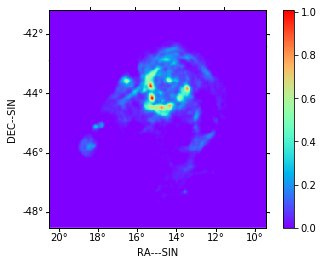

In [5]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = bvt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = bvt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

Predict the visibility from this image

In [6]:
vt = convert_blockvisibility_to_visibility(bvt)
vt = predict_function(bvt, m31image, context='timeslice', arl_config='bandpass-calibration.ini')
bvt = convert_visibility_to_blockvisibility(vt)

convert_visibility: Original 1 rows, 0.079 GB, converted 1752960 rows, 0.183 GB
convert_visibility: Original 1 rows, 0.079 GB, converted 1752960 rows, 0.183 GB
predict_timeslice: predicting using time slices
fit_uvwplane: Fit to 1752960 rows reduces rms w from 28.2 to 0.0 m
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.95950601, -44.97134495)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>
decoalesce_visibility: Filled decoalesced data into template
decoalesce_visibility: Coalesced 1752960 rows, 0.183 GB, decoalesced 1 rows, 0.079 GB


Create a gain table with modest amplitude and phase errors, smootheed over 16 channels

In [8]:
gt = create_gaintable_from_blockvisibility(bvt)
set_parameters('bandpass-calibration.ini', {'phase_error':1.0, 'amplitude_error':0.1, 
                                            'smooth_channels':16})
gt = simulate_gaintable(gt, phase_error=1.0, amplitude_error=0.1, smooth_channels=16)

create_gaintable_from_blockvisibility: times are [0.]
create_gaintable_from_blockvisibility: intervals are [1.]
simulate_gaintable: Simulating amplitude error = 0.1000, phase error = 1.0000


Plot the gains applied

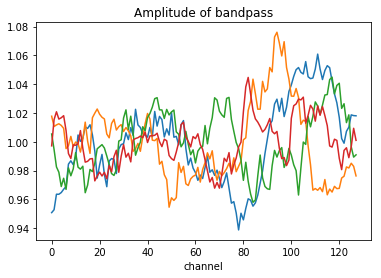

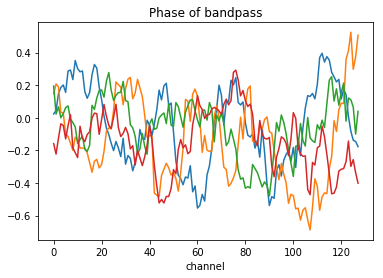

In [9]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    phase = numpy.angle(gt.gain[0,ant,:,0,0])
    plt.plot(phase)
plt.title('Phase of bandpass')
plt.xlabel('channel')
plt.show()

In [10]:
cbvt = copy_visibility(bvt)
cbvt = apply_gaintable(cbvt, gt)

apply_gaintable: Apply gaintable
apply_gaintable: scalar gains


Solve for the gains

In [11]:
gtsol=solve_gaintable(cbvt, bvt, phase_only=False)

solve_gaintable: Solving for complex gain
solve_gaintable: creating new gaintable
create_gaintable_from_blockvisibility: times are [0.]
create_gaintable_from_blockvisibility: intervals are [1.]


Plot the solved relative to the applied. Declare antenna 0 to be the reference.

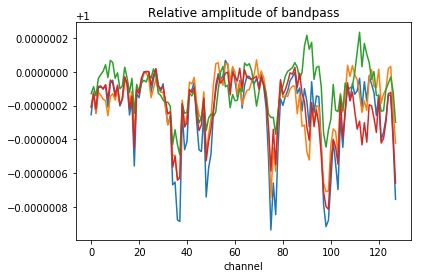

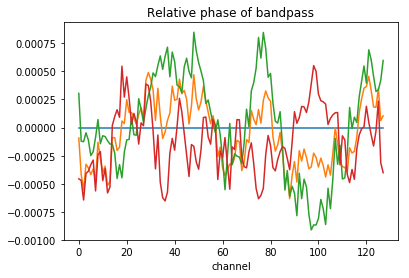

In [12]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Relative amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    refphase = numpy.angle(gtsol.gain[0,0,:,0,0]/gt.gain[0,0,:,0,0])
    phase = numpy.angle(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(phase-refphase)
plt.title('Relative phase of bandpass')
plt.xlabel('channel')
plt.show()

